## Where are WIC Clinics and Vendors located in Allegheny County?
**WIC Clinics** are essential to the enrollment process. They are where applicants are required to go in order to successfully enroll in the program. Thus, proximity to a WIC clinic is critical to understanding the level of need for outreach.

**WIC vendors** are also critical to understanding the state of WIC enrollment in the County. Vendors are the places where program participants can actually spend their benefits. Anecdotal evidence has suggested some participants are detterred from enrolling or continuing in the program because vendors aren't accessible enough.

Here, we will attempt to better understand these trends by creating maps to visualize the distribution of **WIC Vendors** and **WIC Clinics** throughout the County.

In [1]:
# load libraries 
import geopandas as gpd
import pandas as pd 
import os 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format ='retina'
os.chdir('/users/simonw/ds_1300_notebooks/project')

## Data preparation 
First we import the data on where WIC vendors are located around the County. Street addresses are then converted to POINTS for mapping. Next, Census Tract data are loaded back into the environment. 

In [2]:
####### WIC CLINIC LOCATIONS #################

# import address data as .csv file 
wic_clinics = gpd.read_file("data/WIC_Clinics.csv")

# geocoding the addresses
wic_clinics = gpd.tools.geocode(wic_clinics.address)

###### WIC VENDORS LOCATIONS ##################

# import WIC Vender location data
wic_vendors = gpd.read_file("data/AC_WIC_vendors.zip")

###### COUNTY BOUNDARY & CENSUS TRACTS ##############

# import Allegheny County boundary map
ac_boundary = gpd.read_file('data/AC_boundary.zip')

# import Census Tract shape file bounded by Allegheny County
tracts = gpd.read_file('data/tl_2022_42_tract.zip', mask=ac_boundary)

# standardize CRS used by the Census for mapping
wic_vendors = wic_vendors.to_crs(tracts.crs)
wic_clinics = wic_clinics.to_crs(tracts.crs)
ac_boundary = ac_boundary.to_crs(tracts.crs)

## Distribution of Clinics and Vendors

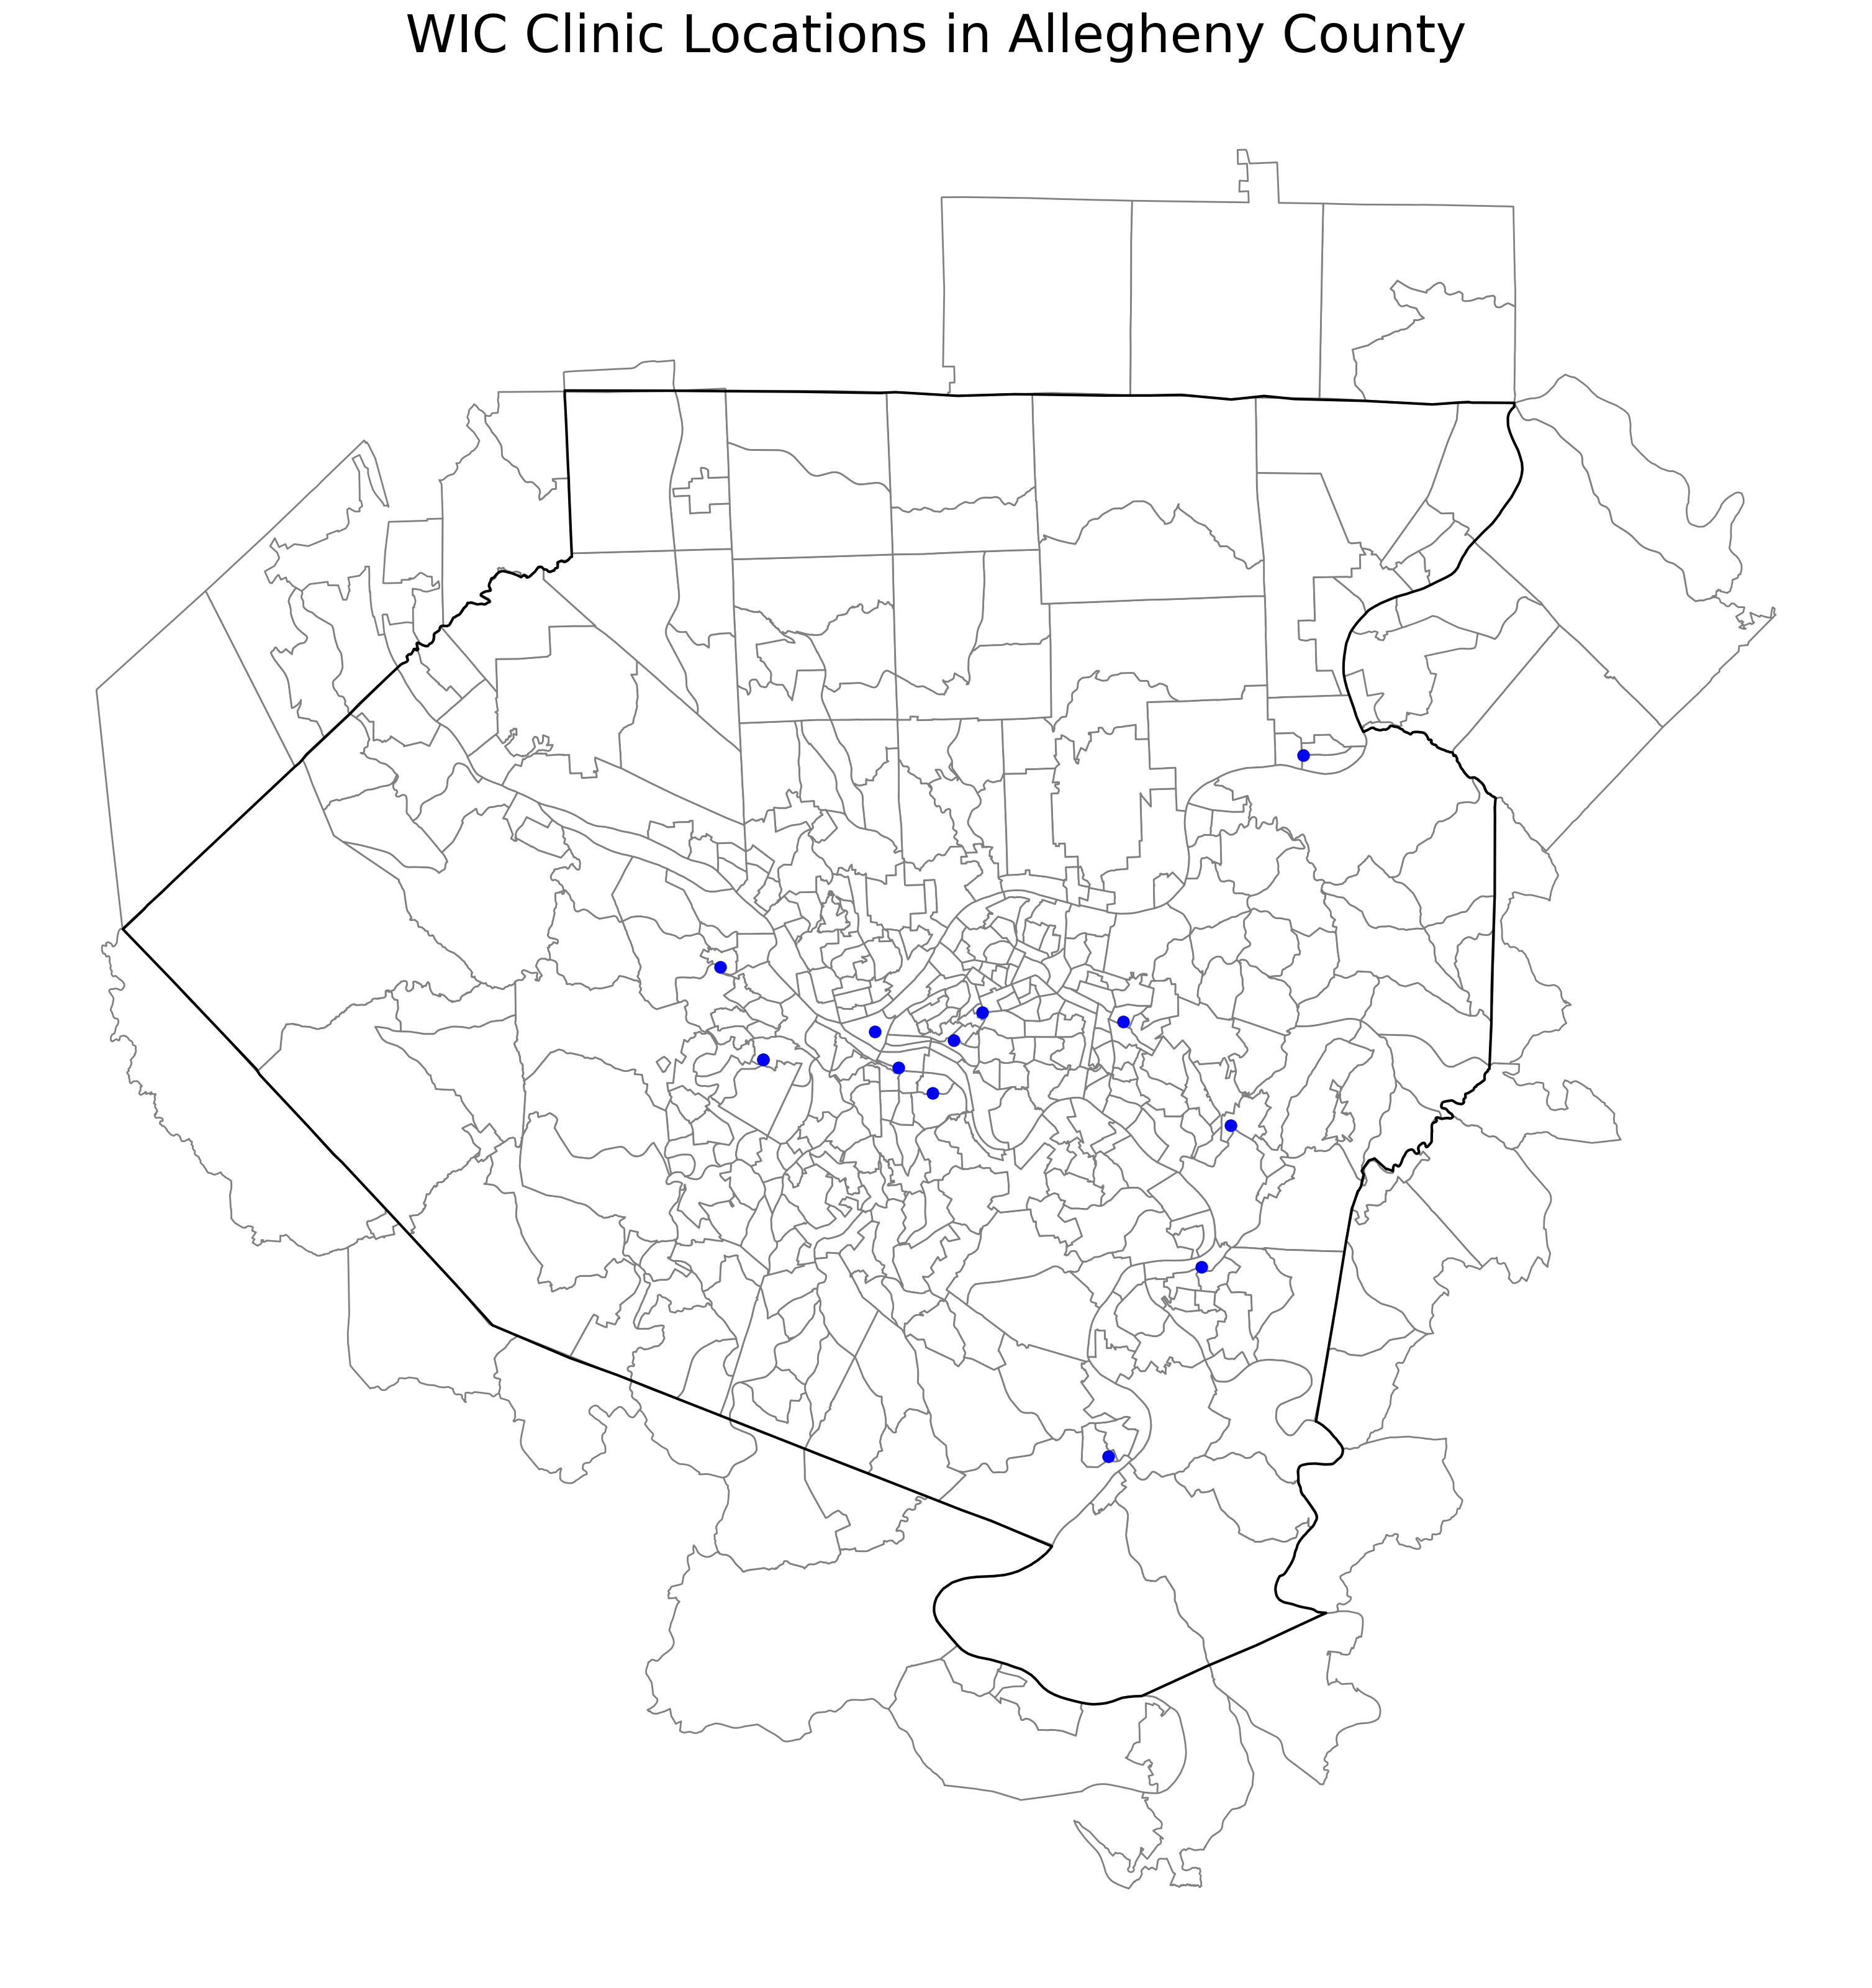

In [3]:
# plotting WIC Clinic locations in Allegheny County by Census Tract
fig, ax=plt.subplots(figsize=(20,20))

tracts.plot(ax=ax, color="white", edgecolor="grey", zorder=1)

ac_boundary.boundary.plot(ax=ax, edgecolor="black", zorder=2)

wic_clinics.plot(ax=ax, marker='o', color='blue', markersize=40, zorder=3)

ax.set_title("WIC Clinic Locations in Allegheny County", fontsize=30)
ax.set_axis_off()

plt.show();

# save plot
fig.savefig(fname='wic_clinic_locations_AC.png', dpi='figure')

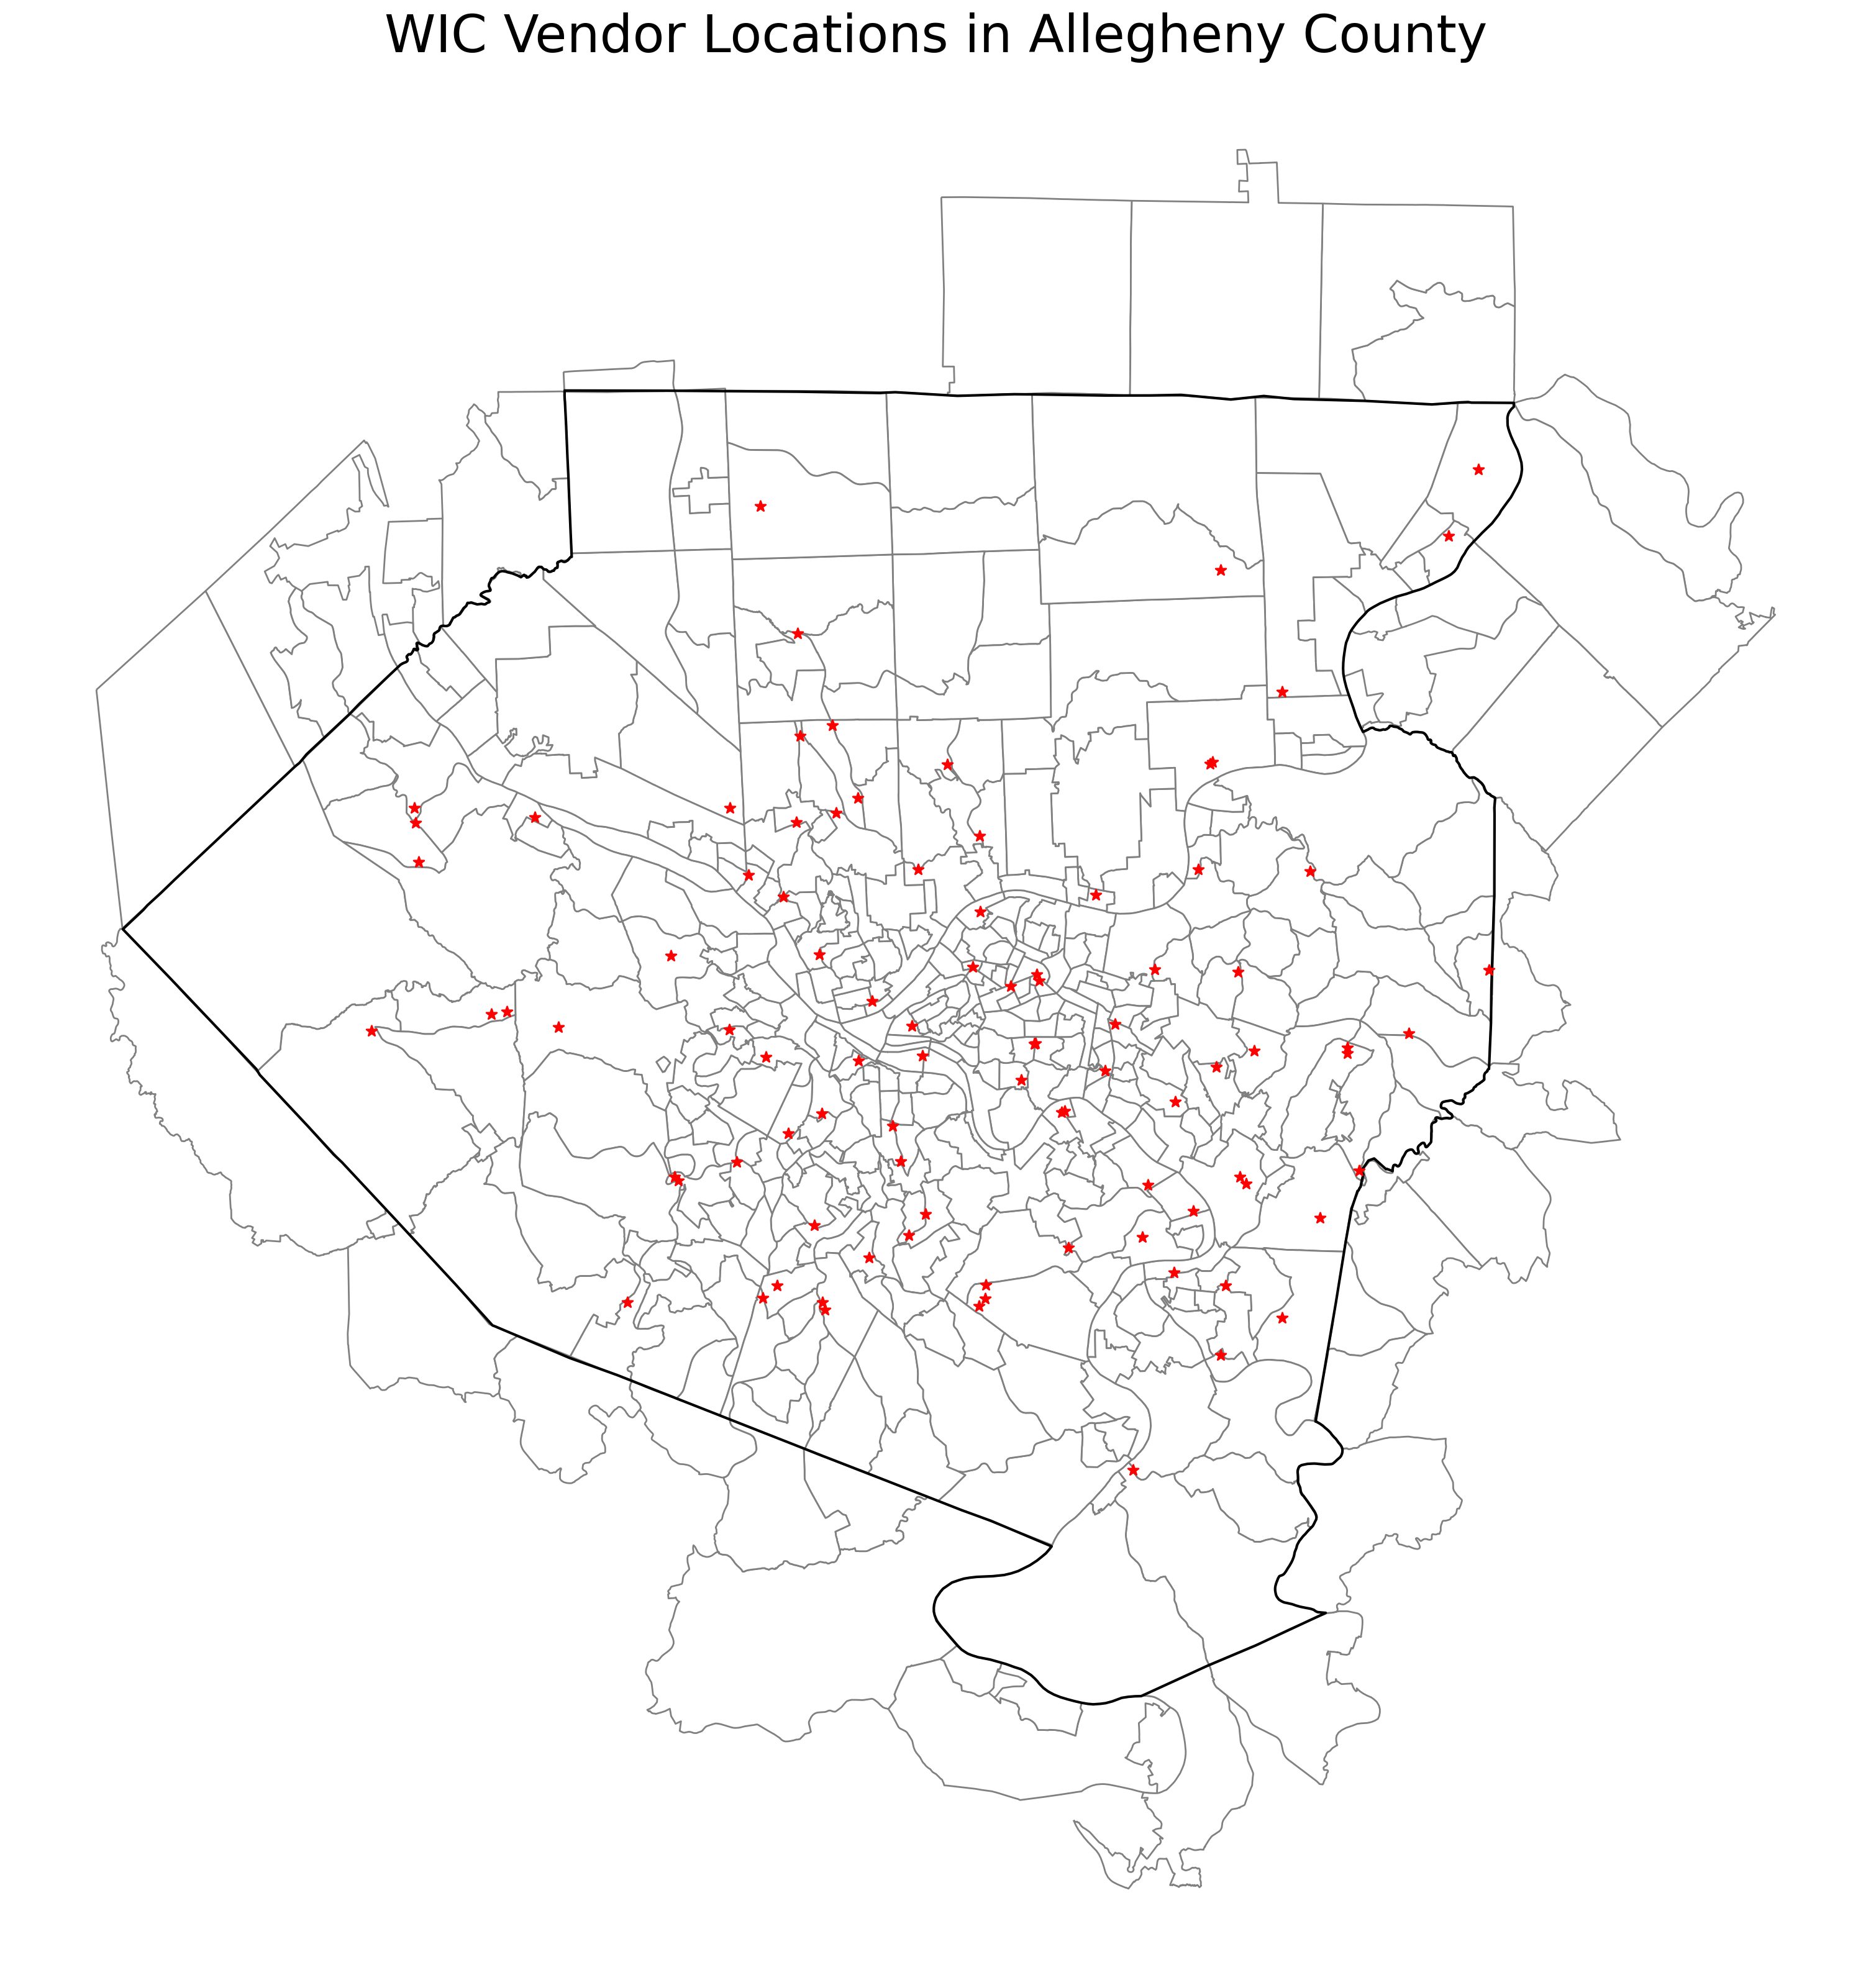

In [4]:
# plotting WIC Vendor locations in Allegheny County by Census Tract
fig, ax=plt.subplots(figsize=(20,20))

tracts.plot(ax=ax, color="white", edgecolor="grey", zorder=1)

ac_boundary.boundary.plot(ax=ax, edgecolor="black", zorder=2)

wic_vendors.plot(ax=ax, marker='*', color='red', markersize=40, zorder=3)

ax.set_title("WIC Vendor Locations in Allegheny County", fontsize=30)
ax.set_axis_off()

plt.show();

# save plot
fig.savefig(fname='wic_vendor_locations_AC.png', dpi='figure')

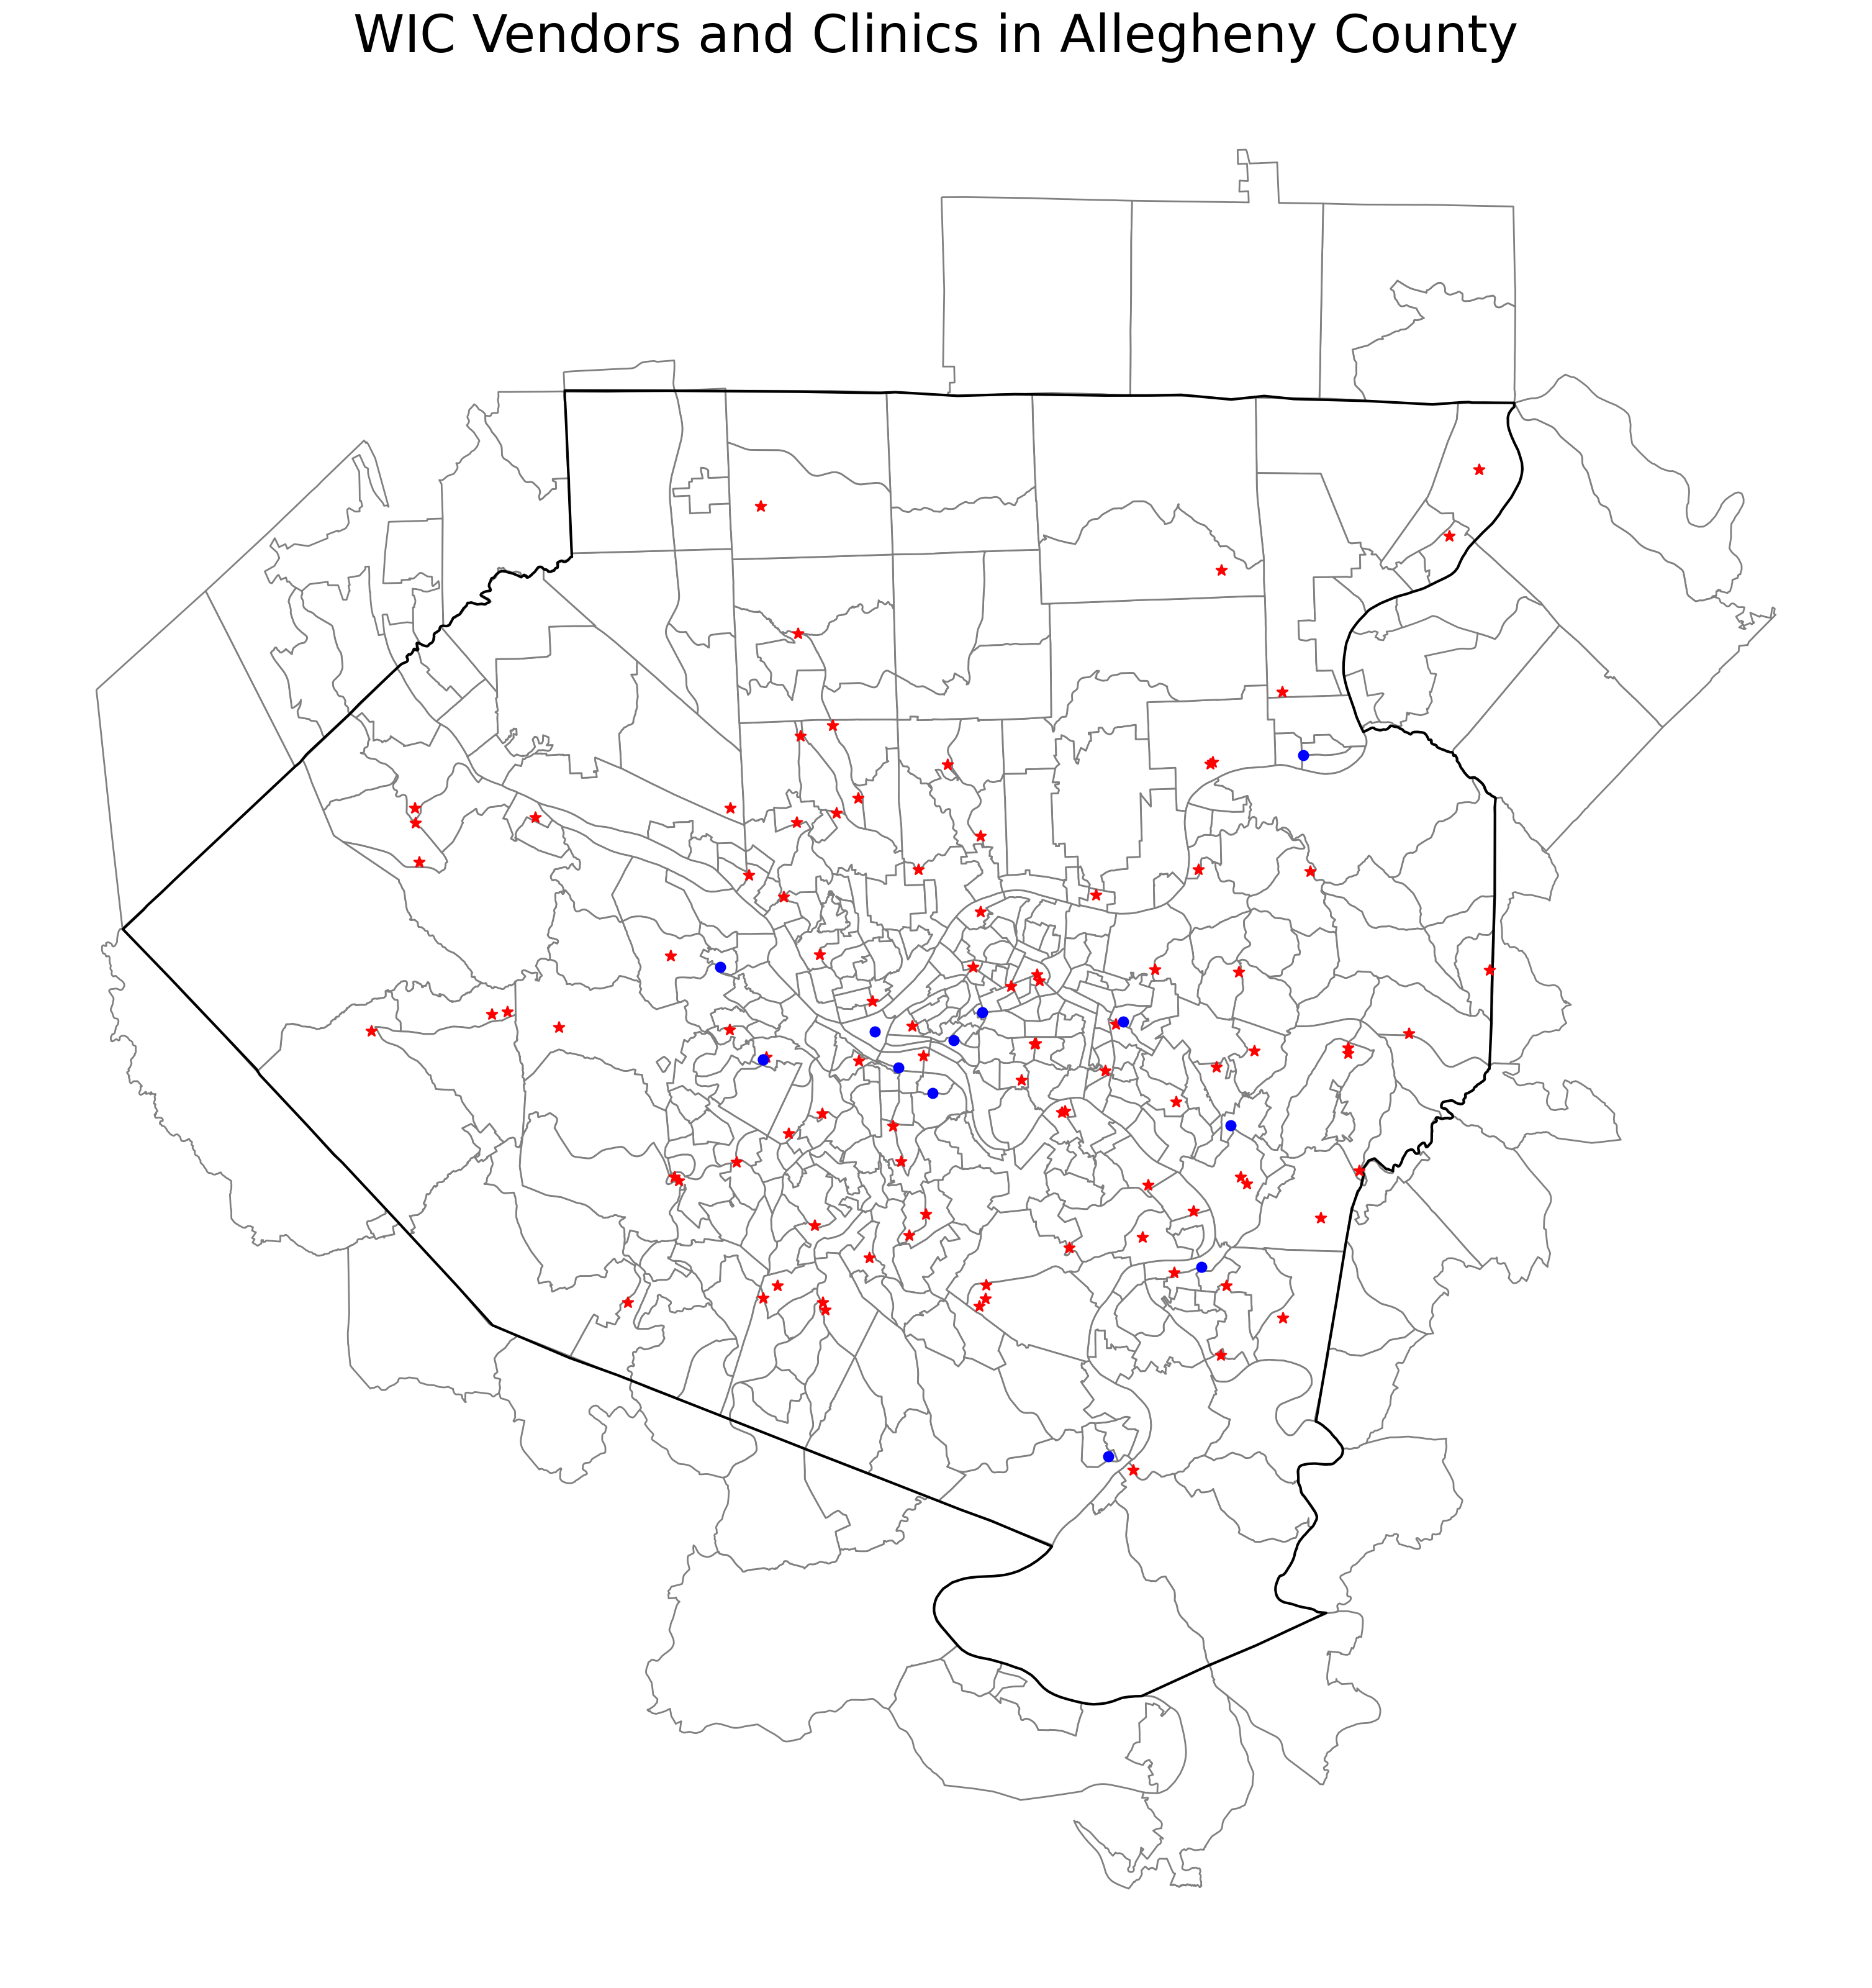

In [5]:
# plotting WIC Vendor and Clinic locations in Allegheny County by Census Tract
fig, ax=plt.subplots(figsize=(20,20))

tracts.plot(ax=ax, color="white", edgecolor="grey", zorder=1)

ac_boundary.boundary.plot(ax=ax, edgecolor="black", zorder=2)

wic_vendors.plot(ax=ax, marker='*', color='red', markersize=40, zorder=3)

wic_clinics.plot(ax=ax, marker='o', color='blue', markersize=30, zorder=4)

ax.set_title("WIC Vendors and Clinics in Allegheny County", fontsize=30)
ax.set_axis_off()

plt.show();

# save plot
fig.savefig(fname='wic_vendor_clinics_AC.png', dpi='figure')

## Distance from Census Tract Centroid to Nearest WIC Vendor
After plotting the existing WIC vendor locations, I will now calculate the distance from centroid to the nearest WIC location using the Manhattan Block Method. 

The Manhattan distance is a different way of measuring distance predicated on the idea that traveling along the hypotenuse (i.e. Euclidean distance) is often not possible because of how roads are planned.

To calculate Manhattan distance, we will need the latitude and longitude of every Census Tract centroid. Then, we will calculate the Manhattan distance from each centroid to *all* store locations before identifying the store with the minimum distance for each.

In [6]:
# change geometry to projected CRS
tracts = tracts.to_crs(epsg=32633)
wic_vendors = wic_vendors.to_crs(epsg=32633)

# calculate the centroid of each Census Tract
tracts['centroid'] = tracts.centroid

In [7]:
# Find the minimum Manhattan Distance
def minimum_manhattan_distance(centroid):
    # 
    vendor_points = wic_vendors['geometry']
    upper_bound = len(vendor_points)
    #
    x1 = centroid.x
    y1 = centroid.y
    x2 = vendor_points.x
    y2 = vendor_points.y
    #
    results = []
    # looping through all of the vendor locations for each input
    for i in range(upper_bound):
        distance = abs(x1 - x2[i]) + abs(y1 - y2[i])
        results.append(distance)

    return min(results)

In [8]:
# calculate the minimum distance to a WIC Vendor from the centroid of every Census Tract
tracts['min_vendor_distance'] = tracts['centroid'].apply(lambda centroid: minimum_manhattan_distance(centroid))

## Distance from Census Tract Centroid to Nearest WIC Clinic
Here we replicate the Manhattan Block Method used previously. 

In [9]:
# change geometry to projected CRS
wic_clinics = wic_clinics.to_crs(epsg=32633)

In [10]:
# redefine the function to use the WIC Clinic points
def minimum_manhattan_distance(centroid):
    # list to store the results in the function 
    clinic_points = wic_clinics['geometry']
    upper_bound = len(clinic_points)
    #
    x1 = centroid.x
    y1 = centroid.y
    x2 = clinic_points.x
    y2 = clinic_points.y
    #
    results = []
    # looping through all of the vendor locations for each input
    for j in range(upper_bound):
        distance = abs(x1 - x2[j]) + abs(y1 - y2[j])
        results.append(distance)

    return min(results)

In [11]:
# calculate the minimum distance to a WIC Clinic from the centroid of every Census TractS
tracts['min_clinic_distance'] = tracts['centroid'].apply(lambda centroid: minimum_manhattan_distance(centroid))

In [12]:
# save distances and tracts with key = GEOID
tracts.to_csv("/users/simonw/ds_1300_notebooks/project/data/AC_census_tracts.csv")

## Adding the index

In [13]:
# import WIC Need Index location data
wic_index = pd.read_csv("/users/simonw/ds_1300_notebooks/project/data/wic_index.csv")

In [14]:
# change data type
wic_index['GEOID'] = wic_index['GEOID'].astype(str)

In [15]:
# slice only necessary columns from WIC Need Index
df = wic_index[['GEOID', 'avg_zscore']]

# merge WIC Need Index with Census Tract data
merged = tracts.merge(df, on='GEOID', how='inner')

In [16]:
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   STATEFP              366 non-null    object  
 1   COUNTYFP             366 non-null    object  
 2   TRACTCE              366 non-null    object  
 3   GEOID                366 non-null    object  
 4   NAME                 366 non-null    object  
 5   NAMELSAD             366 non-null    object  
 6   MTFCC                366 non-null    object  
 7   FUNCSTAT             366 non-null    object  
 8   ALAND                366 non-null    int64   
 9   AWATER               366 non-null    int64   
 10  INTPTLAT             366 non-null    object  
 11  INTPTLON             366 non-null    object  
 12  geometry             366 non-null    geometry
 13  centroid             366 non-null    geometry
 14  min_vendor_distance  366 non-null    float64 
 15  min_clinic_dist

In [17]:
merged.head(3)

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
0      42      003  402000  42003402000  4020  Census Tract 4020  G5020   
1      42      003  423000  42003423000  4230  Census Tract 4230  G5020   
2      42      003  270800  42003270800  2708  Census Tract 2708  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1329046  121186  +40.6079823  -079.7400161   
1        S   908635   92532  +40.4927887  -079.9030596   
2        S  1270793       0  +40.4856961  -080.0319964   

                                            geometry  \
0  POLYGON ((-5802788.399 10611248.708, -5802656....   
1  POLYGON ((-5819536.422 10634068.523, -5819461....   
2  POLYGON ((-5817942.956 10651363.516, -5817887....   

                            centroid  min_vendor_distance  \
0  POINT (-5803129.796 10610019.282)          4390.151964   
1  POINT (-5819779.604 10633378.797)          1882.679278   
2  POINT (-5818789.230 10650006.862)          2189.809456   

   min_clinic_distance  avg_zscore  
0         18616.350234    0.384278  
1         10555.515392    0.133770  
2          8854.597669   -0.398556

In [21]:
# aligning CRS
merged = merged.to_crs(ac_boundary.crs)
wic_clinics = wic_clinics.to_crs(ac_boundary.crs)

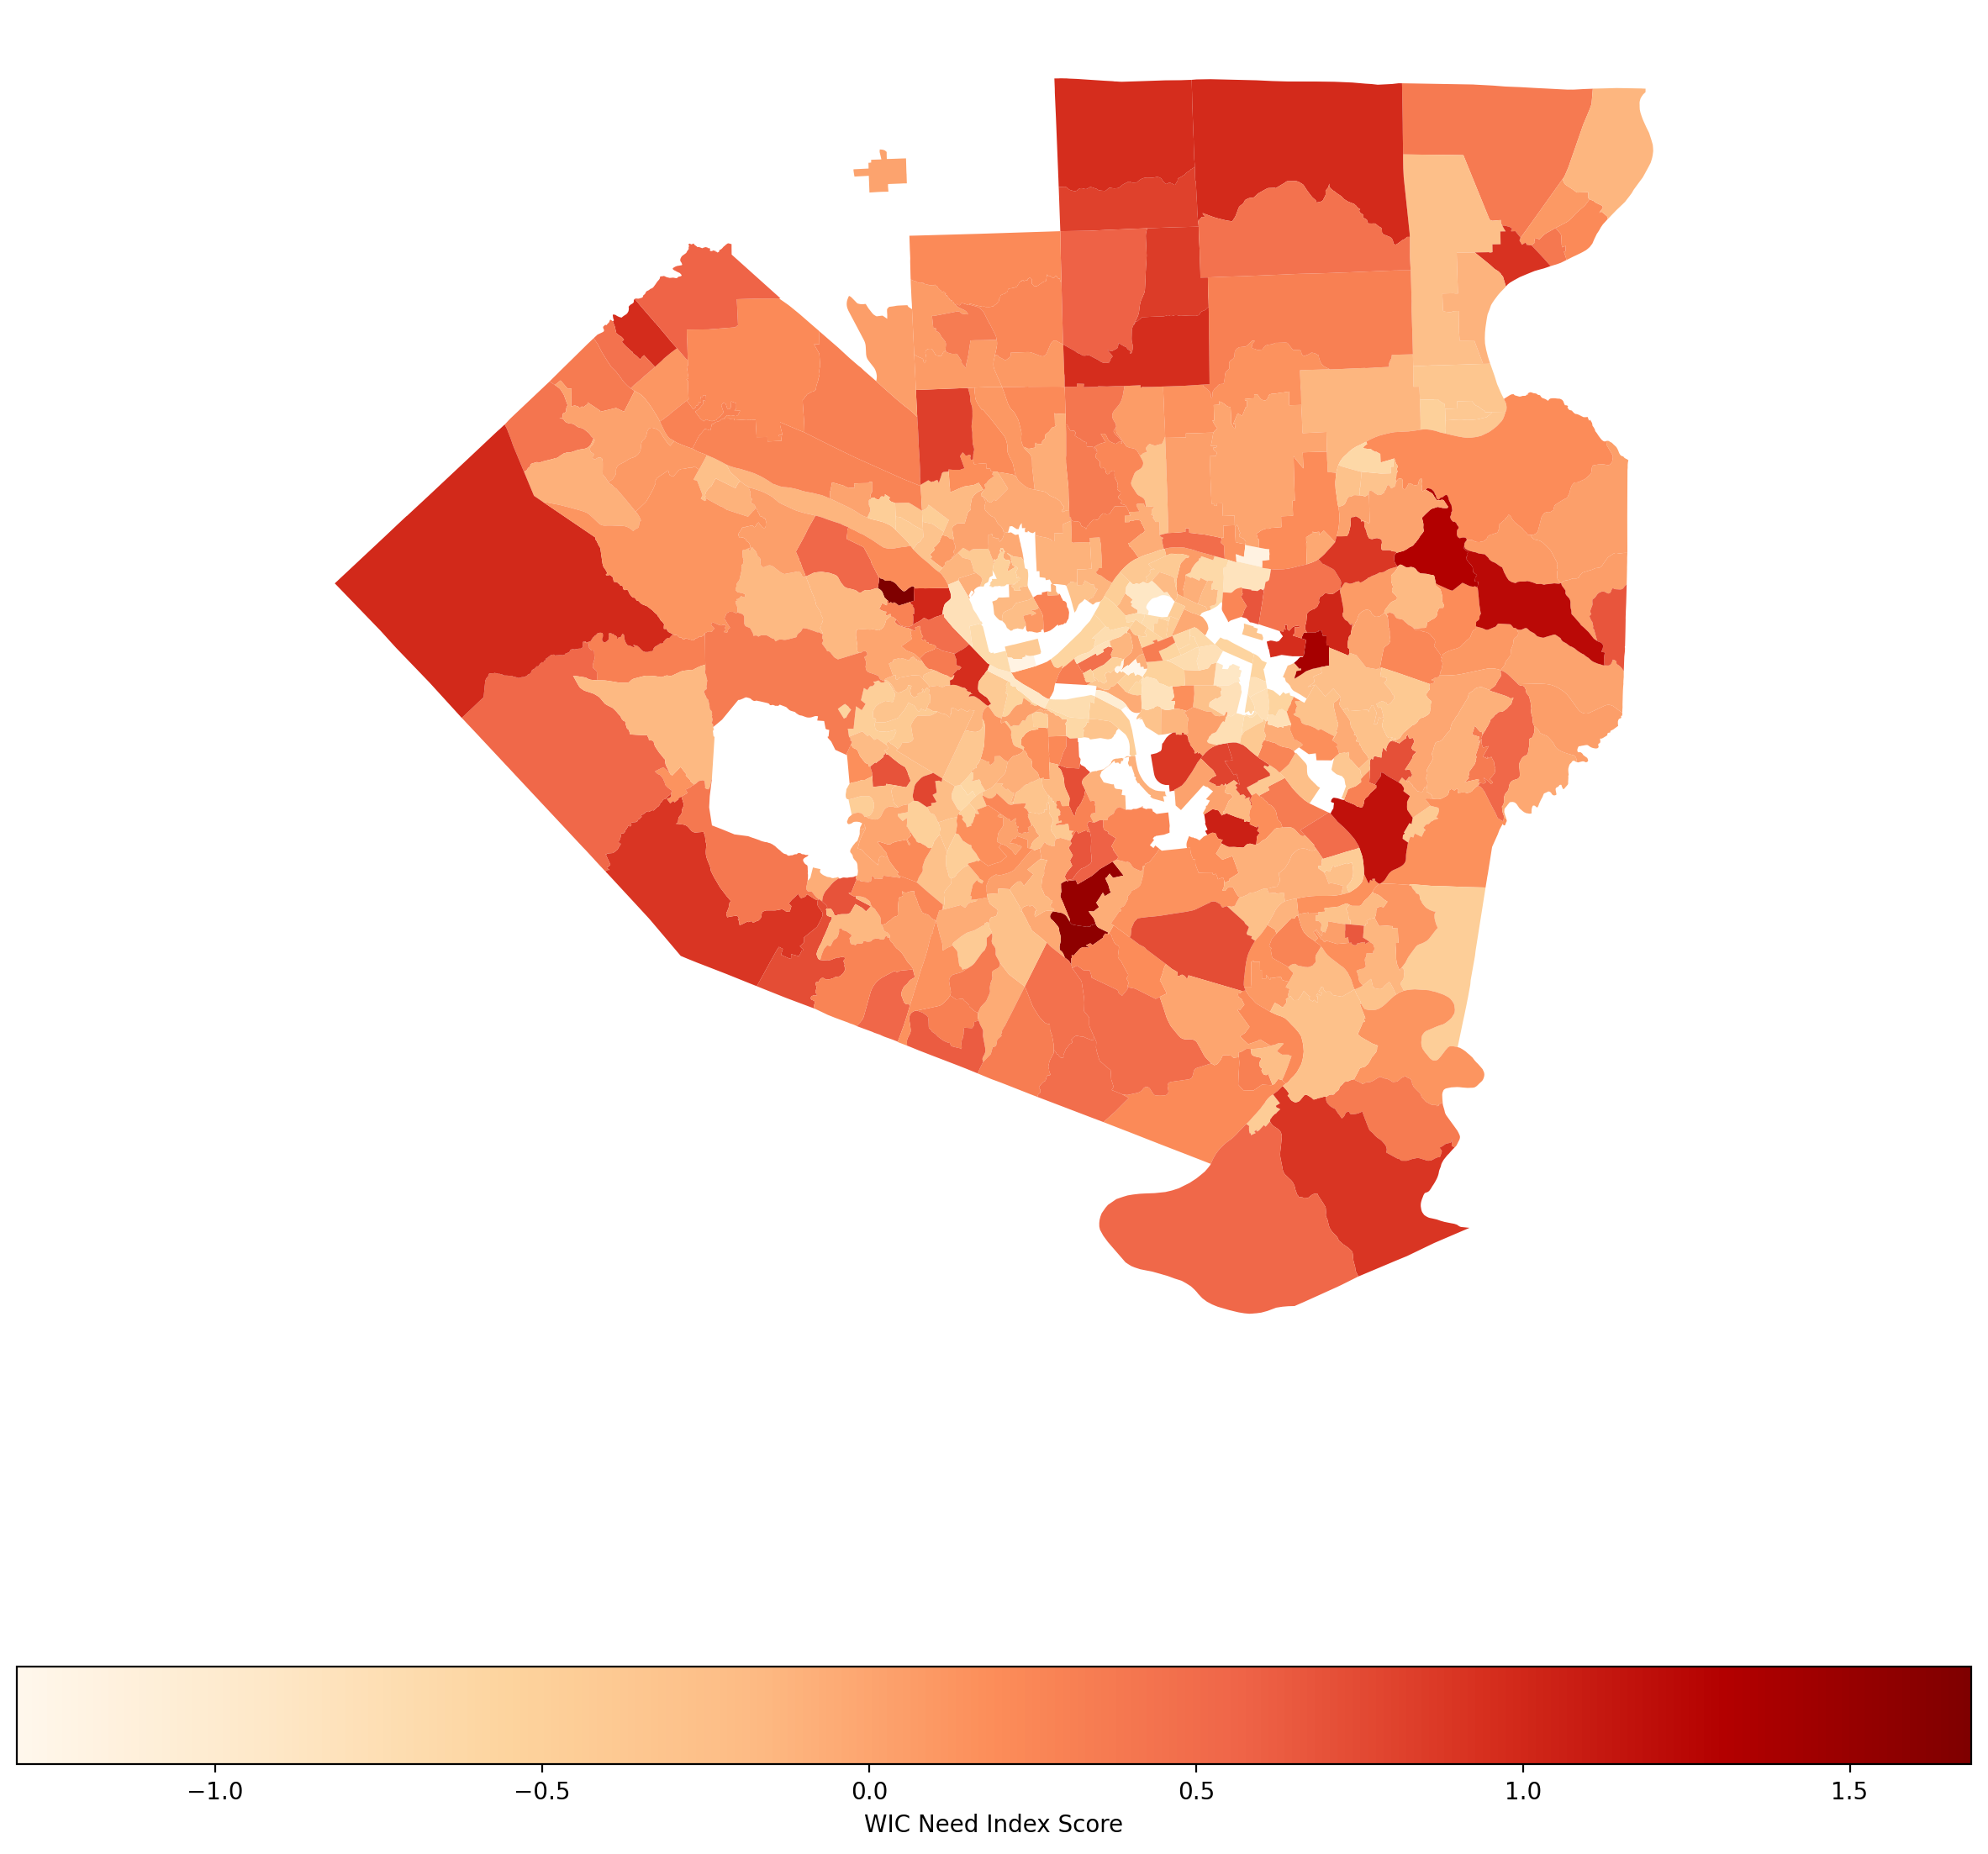

In [24]:
# plotting the distribution of WIC Need in Allegheny County by Census Tract
fig, ax=plt.subplots(figsize=(15,15))

merged.plot(ax=ax, column='avg_zscore',
            cmap='OrRd', legend=True,
            legend_kwds={"label": "WIC Need Index Score", "orientation": "horizontal"},)

ax.set_axis_off()

plt.show();

# save plot
fig.savefig(fname='wic_need_AC.png', dpi='figure')

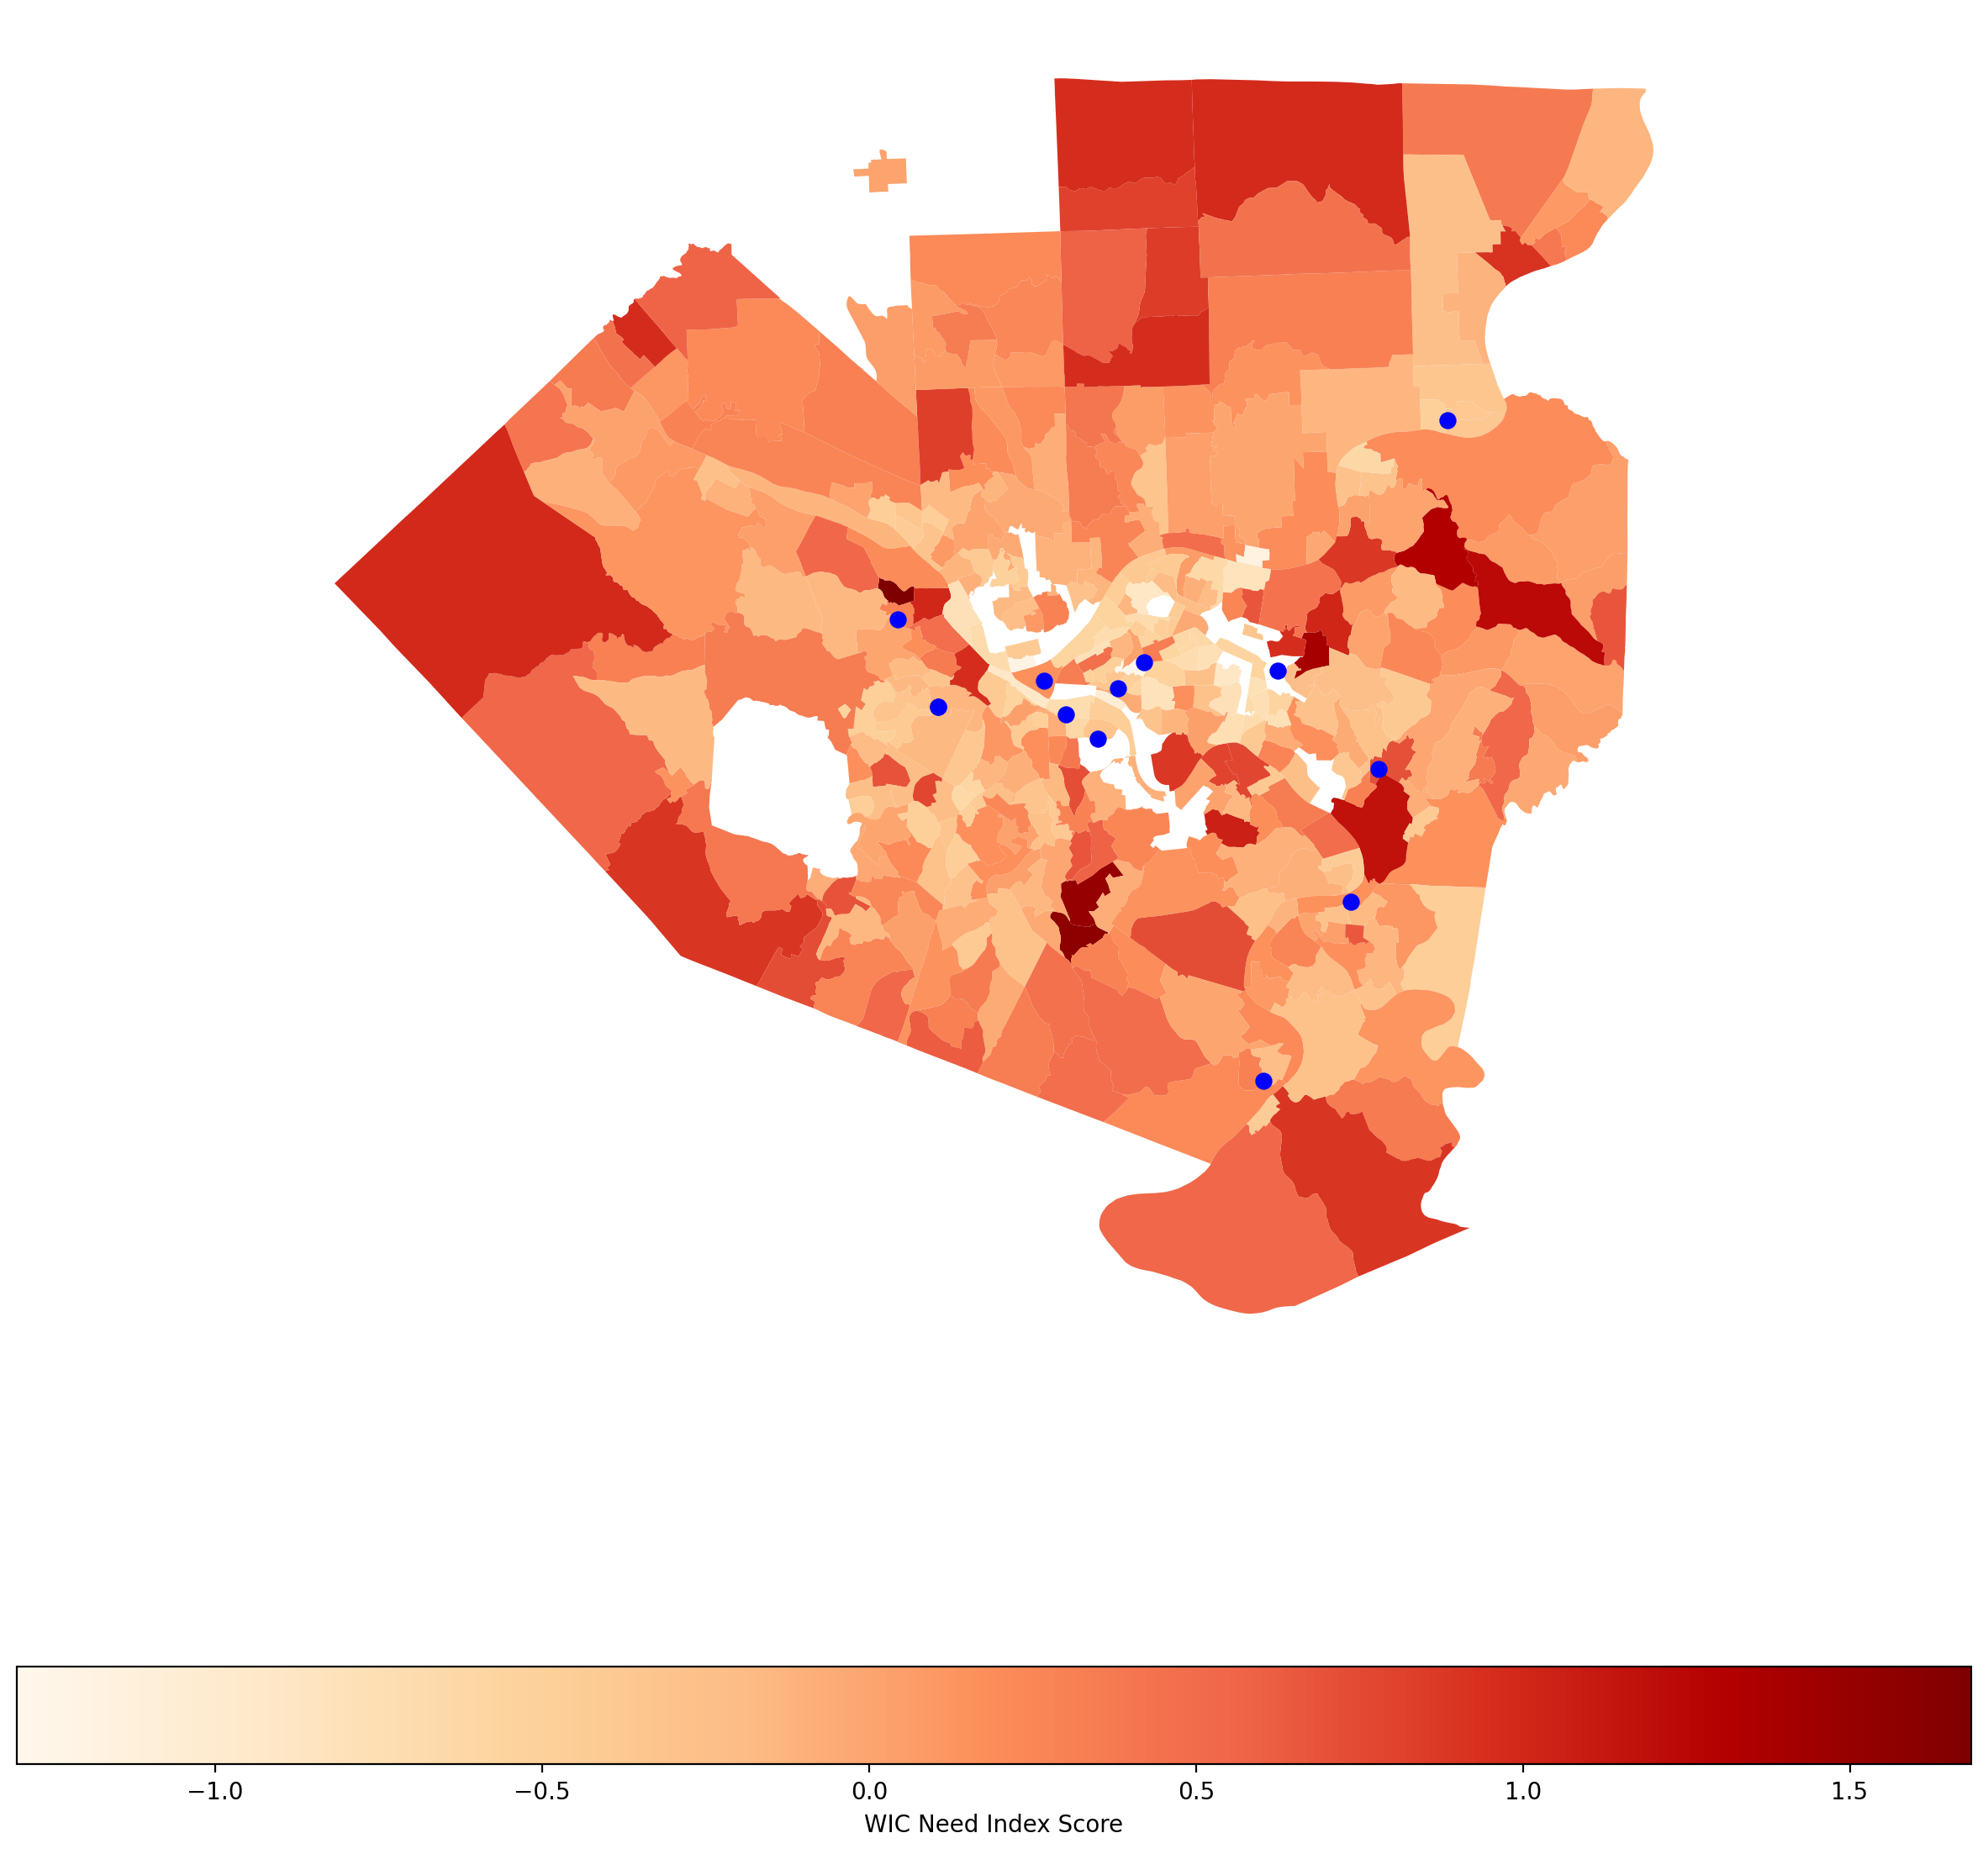

In [23]:
# plotting WIC Clinics onto the distribution of WIC Need in Allegheny County by Census Tract
fig, ax=plt.subplots(figsize=(15,15))

merged.plot(ax=ax, column='avg_zscore',
            cmap='OrRd', legend=True,
            legend_kwds={"label": "WIC Need Index Score", "orientation": "horizontal"},)

wic_clinics.plot(ax=ax, marker='o', color='blue', markersize=40, zorder=1)

ax.set_axis_off()

plt.show();

# save plot
fig.savefig(fname='wic_clinics_and_need_AC.png', dpi='figure')